使用pythorch加速运算的lowrankSNN

In [34]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.distributions as dist
from functions import Draw_Output, Draw_Conductance, Draw_RasterPlot, Draw_Voltage, Draw_Projection, save_model, load_config_yaml
from lowranksnn import LowRankSNN


In [35]:
# Read the configuration file
config = load_config_yaml('config_test.yaml')
# config = load_config_yaml('config_ING.yaml')

N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
RS = config['RandomStrength']
taud_E = config['taud_E']
taud_I = config['taud_I']
mask_tauE = torch.rand(1, N_E) < 0.2
mask_tauI = torch.rand(1, N_I) < 0.2
tau_E = torch.ones(1, N_E) * 100
tau_E[mask_tauE] = 2
tau_I = torch.ones(1, N_I) * 100
tau_I[mask_tauI] = 5

mu = config['mu']
si = config['sigma']

mu_rand = config['mu_rand']
si_rand = config['sigma_rand']

dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)

color_Go = config['color_Go']
color_Nogo = config['color_Nogo']


In [36]:
# Initialiazation

LRSNN = LowRankSNN(N_E=N_E,N_I=N_I,RS= RS,taud_E=taud_E,taud_I=taud_I)


# LRSNN = LowRankSNN(N_E=400,N_I=100,RS= 0.1,taud_E=2,taud_I=5)
#low rank文献的N=5000
# Go_NoGo Task
# Prepare the Stimuli and Readout Vector
temp = torch.rand(1,LRSNN.N_E+LRSNN.N_I) #Size (1,N_E) for Sti_go and nogo #这里我想试试把Low Rank加到整个网络上
Sti_go = temp.clone()
Sti_nogo = temp.clone()
W_out = temp.clone()


# 这里可以注意把sti_go和sti_nogo的norm都归一化到1(比如取消input strength，改成用归一化后的norm来控制)
Sti_go[Sti_go>1/3] = 0 # n
Sti_nogo[Sti_nogo<1/3] = 0
Sti_nogo[Sti_nogo>2/3] = 0
W_out[W_out<2/3] = 0 # m

# Sti_go[Sti_go>1/30] = 0
# Sti_nogo[Sti_nogo<15/30] = 0
# Sti_nogo[Sti_nogo>16/30] = 0
# W_out[W_out<29/30] = 0


# Use Gamma Distribution to generate Stimuli and Readout Vector
# mean and std of Gamma Distribution(Deside Sti_go,Sti_nogo,W_out,conn_rand)
# mu = 0.1
# mu = 50
# mu = 1
# mu = 10
# mu = 20
# mu = 2
# 创建Gamma分布

# si = 10
# si = np.sqrt(1/LRSNN.N_E+LRSNN.N_I)
# si = 2

b = mu/si**2
a = mu*b
gamma_dist = dist.gamma.Gamma(a, b)

Sti_go[Sti_go!=0] = gamma_dist.sample((len(torch.nonzero(Sti_go)),)) #random.gamma(shape(a), scale(b)=1.0, size=None),这个地方的Gamma分布及其参数选取需要进一步讨论
Sti_nogo[Sti_nogo!=0] = gamma_dist.sample((len(torch.nonzero(Sti_nogo)),))
W_out[W_out!=0] = gamma_dist.sample((len(torch.nonzero(W_out)),))
W_out = np.transpose(W_out) #Size (N_E,1)
# Low Rank Connectivity (Rank = 1)
conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数?


# conn_LR[conn_LR>1] = 1
# Random Connectivity
mu_rand = 1/(LRSNN.N_E+LRSNN.N_I)
# mu_rand = 10/(LRSNN.N_E+LRSNN.N_I)
# mu_rand = 400/(LRSNN.N_E+LRSNN.N_I)
si_rand = 100/(LRSNN.N_E+LRSNN.N_I)
b_rand = mu_rand/si_rand**2
a_rand = mu_rand*b_rand
gamma_dist_rand = dist.gamma.Gamma(a_rand, b_rand)
conn_rand = gamma_dist_rand.sample(((LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I))) #这里的Gamma分布取值也需要讨论

# # Use Folded Normal Distribution to generate Stimuli and Readout Vector

# std_Sti = 2. #Standerd Deviration of Stimuli
# std_Wout = 2. #Standerd Deviration of readout matrix

# Sti_go[Sti_go!=0] = torch.abs(torch.normal(mean=0,std=std_Sti,size=(len(torch.nonzero(Sti_go)),)))
# Sti_nogo[Sti_nogo!=0] = torch.abs(torch.normal(mean = 0,std = std_Sti,size = (len(torch.nonzero(Sti_nogo)),)))
# W_out[W_out!=0] = torch.abs(torch.normal(mean = 0,std = std_Wout,size = (len(torch.nonzero(W_out)),)))
# W_out = np.transpose(W_out) #Size (N,1)
# conn_LR = W_out*Sti_go/(LRSNN.N_E+LRSNN.N_I) # 为什么除以神经元总数? # Low Rank Connectivity (Rank = 1)
# conn_rand = torch.abs(torch.normal(0,1/np.sqrt(LRSNN.N_E+LRSNN.N_I),(LRSNN.N_E+LRSNN.N_I,LRSNN.N_E+LRSNN.N_I))) # Random Connectivity

m = W_out #m = Wout
n = Sti_go #n = Stigo

# Assemble the Network
LRSNN.add_lowrank(conn_LR, W_out)
LRSNN.add_random(conn_rand)

LRSNN.conn[LRSNN.conn>1] = 1


Low Rank connection and readout vector have been added.
Random connection has been added.


矩阵的秩: 540
非零元素的比例: 1.0


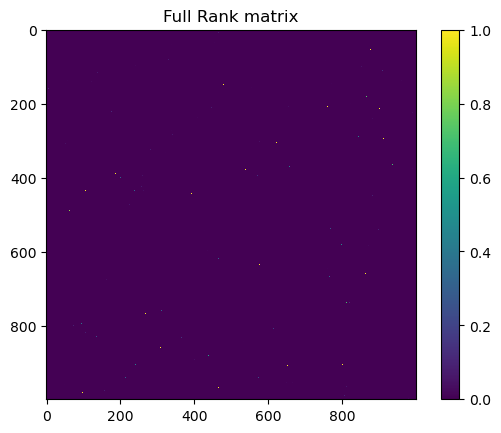

m norm: tensor(3.3994)
n norm: tensor(4.5031)
Sti_nogo norm: tensor(4.3487)
torch.Size([1000, 1]) torch.Size([1, 1000]) torch.Size([1, 1000])


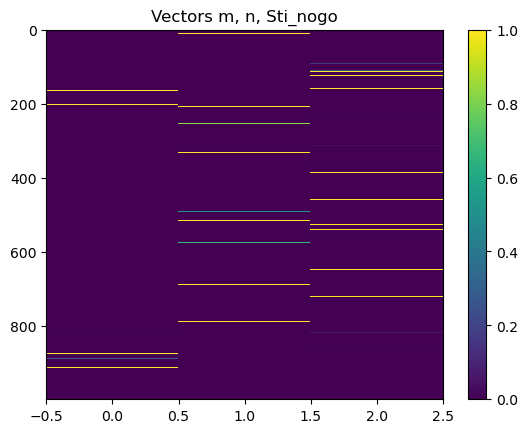

0.0
0.0
0.0
tensor(13.5216) tensor(1.)


In [38]:

conn_rand[conn_rand>1] = 1
m[m>1] = 1
n[n>1] = 1
Sti_go[Sti_go>1] = 1
Sti_nogo[Sti_nogo>1] = 1
W_out[W_out>1] = 1

rank = np.linalg.matrix_rank(conn_rand)
print("矩阵的秩:", rank)
print("非零元素的比例:", np.count_nonzero(conn_rand) / (N * N))

plt.figure()
plt.imshow(conn_rand,interpolation='nearest')
plt.colorbar()
plt.title('Full Rank matrix')
plt.show()

print("m norm:", torch.norm(m))
print("n norm:", torch.norm(n))
print("Sti_nogo norm:", torch.norm(Sti_nogo))
# draw the vectors m, n, Sti_nogo in heatmap
plt.figure()
print(m.shape, n.shape, Sti_nogo.shape)
plt.imshow(torch.cat((m, n.T, Sti_nogo.T), 1), aspect='auto',interpolation='nearest')
plt.colorbar()
plt.title('Vectors m, n, Sti_nogo')
plt.show()
print(np.dot(Sti_go.squeeze(),Sti_nogo.squeeze()))
print(np.dot(Sti_go.squeeze(),W_out.squeeze()))
print(np.dot(Sti_nogo.squeeze(),W_out.squeeze()))
print(torch.max(conn_LR),torch.max(conn_rand))

Network Settings
Number of Neurons:  tensor(1000)
Number of Excitatory Units:  tensor(800)
Number of Inhibitory Units:  tensor(200)
Zero Weights occupy: 0.00 %


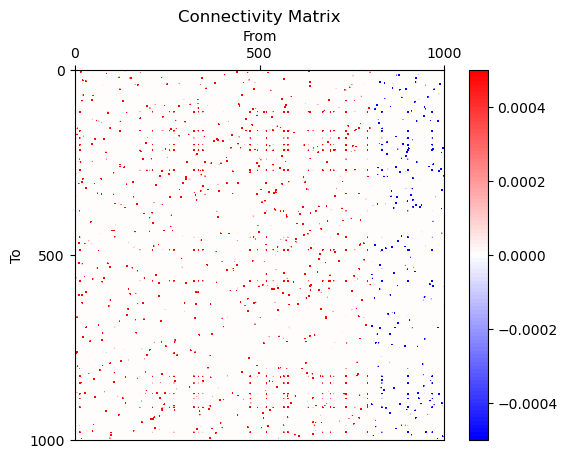

In [37]:
# Show the Network information before simulaiton
# LRSNN = LowRankSNN(N_E=400,N_I=100,RS= 1,taud_E=2,taud_I=5)
LRSNN.show()
# LRSNN.show_conn(maxvalue=0.005)
# LRSNN.show_conn(maxvalue=0.05)
LRSNN.show_conn(maxvalue=0.0005) #这里也许也可以优化一下
# LRSNN.show_conn(maxvalue=0.1)

In [25]:
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms


Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go.T
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo.T

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)

# Start Simulation
Out_go, V_go, g_go, spk_step_go, spk_ind_go = LRSNN(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_step_nogo, spk_ind_nogo = LRSNN(dt,Input_nogo)

Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [26]:

prop = torch.max(Out_go)/torch.max(Out_nogo)
print('Performance: ', prop.item())


Performance:  3130790912.0


In [27]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
# spk_go = spk_go.cpu().numpy()
# spk_nogo = spk_nogo.cpu().numpy()
m = m.cpu().numpy()
n = n.cpu().numpy()
Sti_go = Sti_go.cpu().numpy()
Sti_nogo = Sti_nogo.cpu().numpy()

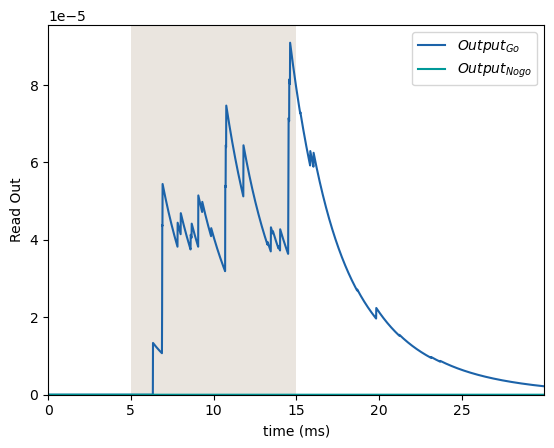

In [28]:

# Draw the results
# color_Go = '#1C63A9'
# color_Nogo = '#009999'

# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

14.873575 0.00025
0.17542006 0.00025


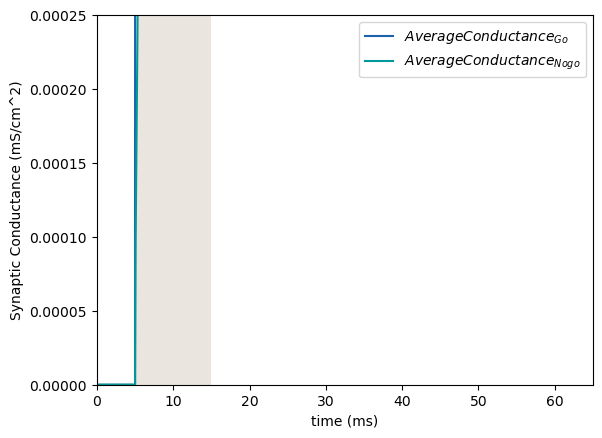

In [122]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.00025])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.00025])

In [112]:
# # Monitor the Voltage
# fig, ax = plt.subplots()
# Draw_Voltage(ax,V_go[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_go)
# Draw_Voltage(ax,V_go[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_go)
# fig, ax = plt.subplots()
# Draw_Voltage(ax,V_nogo[0:LRSNN.N_E,:],'red','Excitatory Neurons_{Go}',dt,Input_nogo)
# Draw_Voltage(ax,V_nogo[LRSNN.N_E:,:],'blue','Inhibitory Neurons_{Go}',dt,Input_nogo)

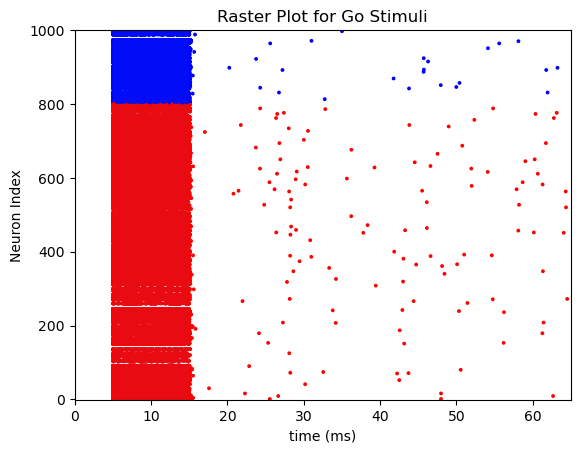

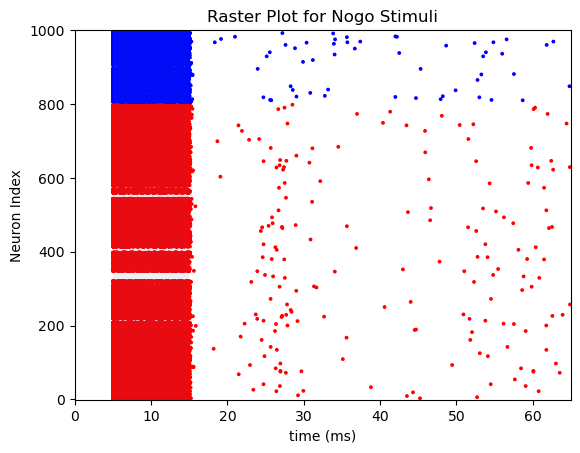

In [123]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_step_go, spk_ind_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

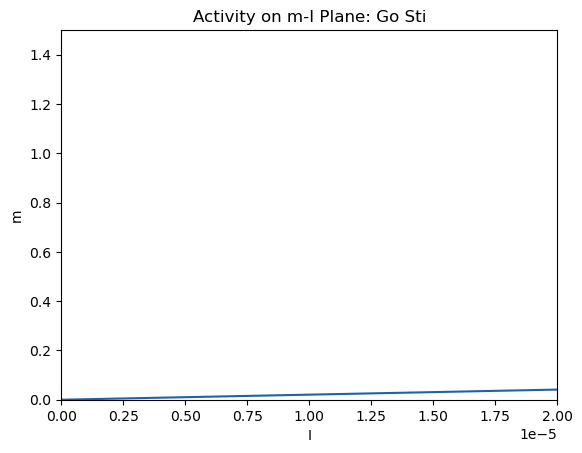

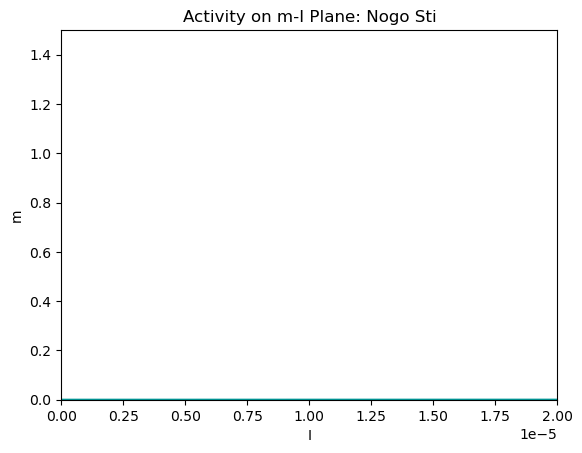

In [20]:
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,1.5],xlim=[0,0.00002])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,1.5],xlim=[0,0.00002])

In [25]:
# 保存模型
save_model(LRSNN,dt,Sti_go,Sti_nogo,Input_go,Input_nogo,IS,m,n)

In [36]:
# 将兴奋性神经元改为抑制性神经元
# 导入网络

# model = torch.load('/SanDisk/Li/LowRank_ModifiedTheta_SNN/PYTHON/models/2024_03_02_07_56.pth')
# LRSNN = model['model']
# Input_go = model['Input_go'].cpu()
# Input_nogo = model['Input_nogo'].cpu()
# dt = model['dt']
# Sti_go = model['Sti_go']
# Sti_nogo = model['Sti_nogo']
# Input_go = model['Input_go']
# Input_nogo = model['Input_nogo']
# m = model['m']
# n = model['n']

LRSNN.N_E = torch.tensor(4000)
LRSNN.N_I = torch.tensor(1000)

Input_go = torch.tensor(Input_go)
Input_nogo = torch.tensor(Input_nogo)

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)

# Start Simulation
Out_go, V_go, g_go, spk_go = LRSNN(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN(dt,Input_nogo)




Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


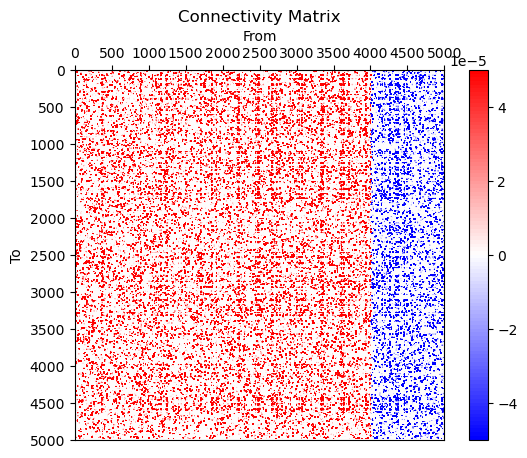

In [37]:
LRSNN.show_conn(maxvalue=0.00005)


In [ ]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()
Sti_go = Sti_go.cpu().numpy()
Sti_nogo = Sti_nogo.cpu().numpy()

In [42]:
# perf = torch.max(Out_go)/torch.max(Out_nogo)
perf = np.max(Out_go)/np.max(Out_nogo)
print('Performance: ', perf.item())

Performance:  18623.693359375


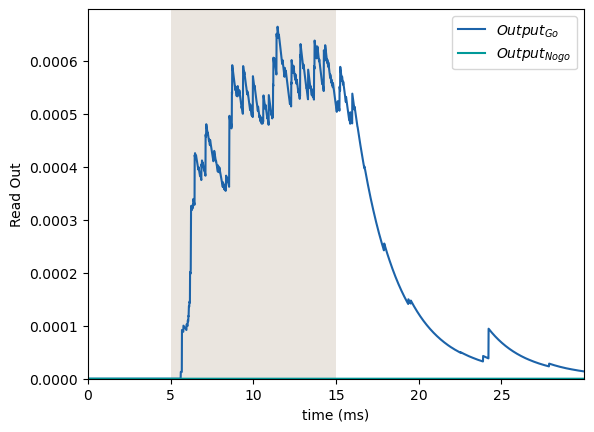

In [40]:

# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

0.0035134824 0.00025
0.00033061326 1e-05


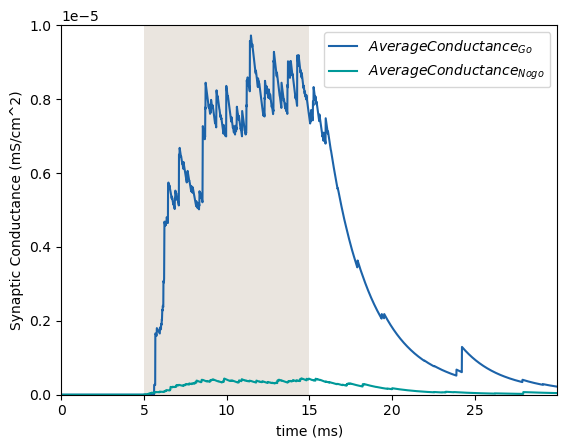

In [44]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.00025])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.00001])

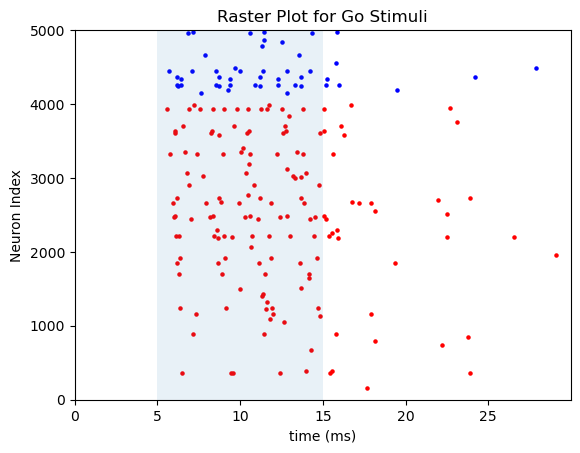

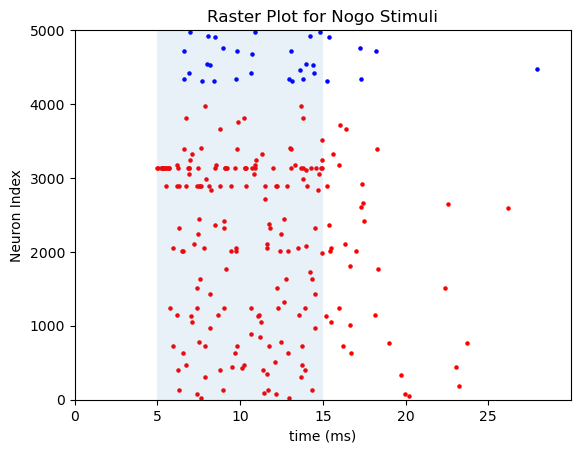

In [45]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

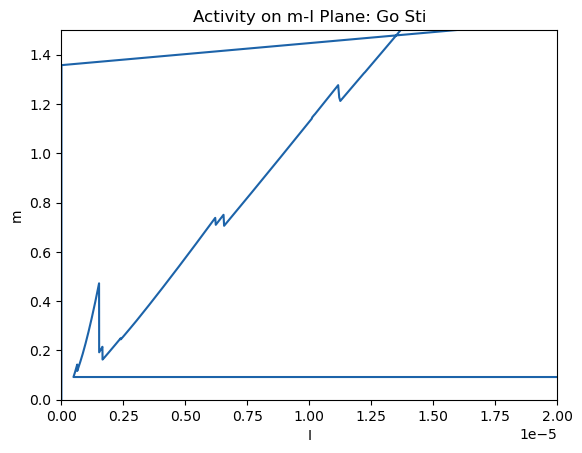

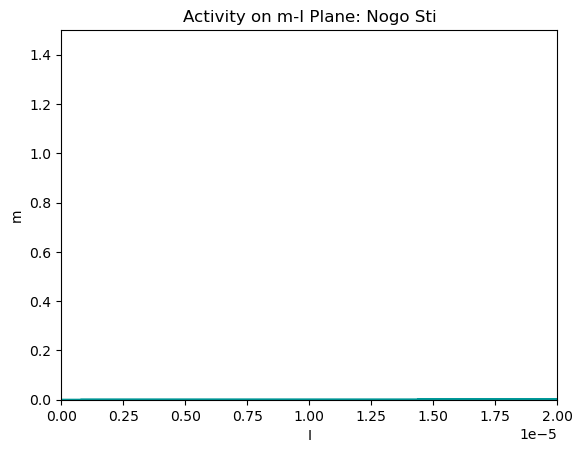

In [46]:
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,1.5],xlim=[0,0.00002])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,1.5],xlim=[0,0.00002])

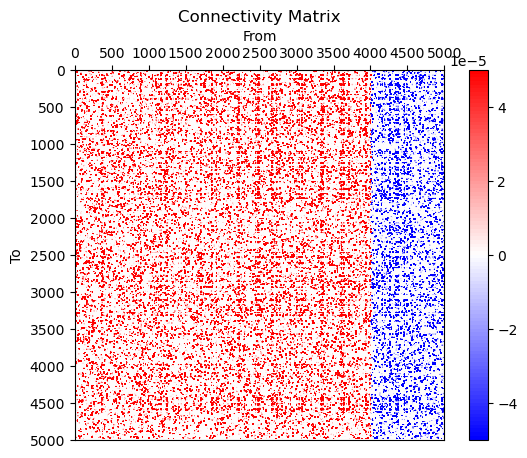

In [55]:
# 引入对synaptic decay time 的限制

# 导入3/5号之后的一个网络
model = torch.load('/SanDisk/Li/LowRank_ModifiedTheta_SNN/PYTHON/models/2024_03_05_08_56.pth')
#将tau_E和tau_I都改为100做测试
LRSNN = model['model']
# Input_go = model['Input_go']
# Input_nogo = model['Input_nogo']
Sti_go = torch.tensor(model['Sti_go'])
Sti_nogo = torch.tensor(model['Sti_nogo'])
dt = model['dt']
# 改变N_E和N_I
LRSNN.N_E = torch.tensor(4000)
LRSNN.N_I = torch.tensor(1000)
# 为了延长模拟时间，改变dt
dt = 0.1 #(ms/step)
T_pre = 5 # length of time before sti (ms)
T_sti = 10 # length of time for sti (ms)
# T_sti = 20 # length of time for sti (ms)
# T_after = 15 # length of time after sti (ms)
# T_after = 80 # length of time after sti (ms)
# T_after = 480 # length of time after sti (ms)
T_after = 975 # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms
IS = model['IS'] #Input Strength
# IS = 1 #Input Strength
Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_go.T
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = IS*Sti_nogo.T

# print(Input_go.device)

# #延长刺激时间到1000ms
# # T_perlong = 70 # ms 
# T_perlong = 970 # ms 
# Input_perlong = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T_perlong/dt)))
# Input_go = torch.cat((Input_go,Input_perlong),dim=1)
# Input_nogo = torch.cat((Input_nogo,Input_perlong),dim=1)

LRSNN.show_conn(maxvalue=0.00005)
#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)


In [56]:

# 测试原来的仅有fast的结果
# dt = 10
# Start Simulation
Out_go, V_go, g_go, spk_go = LRSNN(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN(dt,Input_nogo)


Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [57]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()
# m = m.cpu().numpy()
# n = n.cpu().numpy()
# Sti_go = Sti_go.cpu().numpy()
# Sti_nogo = Sti_nogo.cpu().numpy()

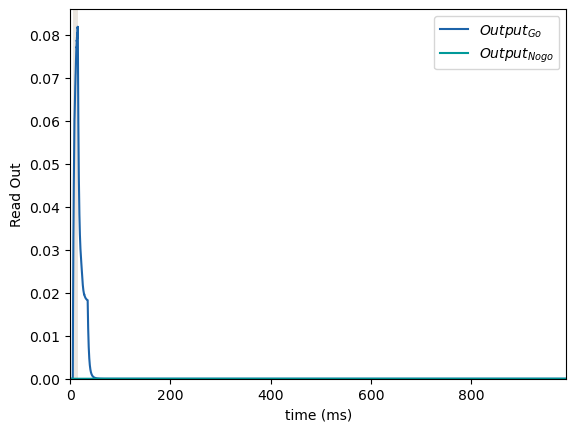

In [58]:

# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

0.49065563 5e-06
0.01420769 0.002


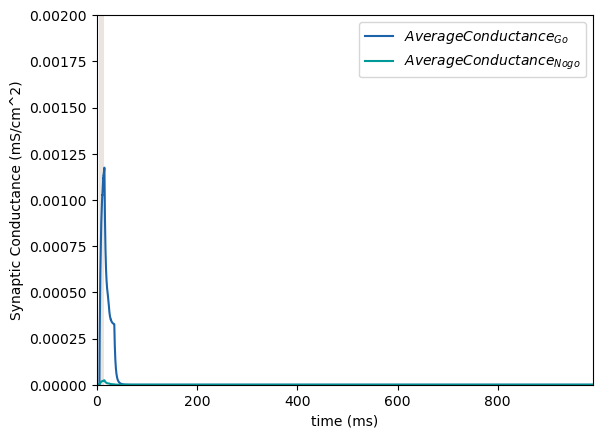

In [63]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.000005])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.002])

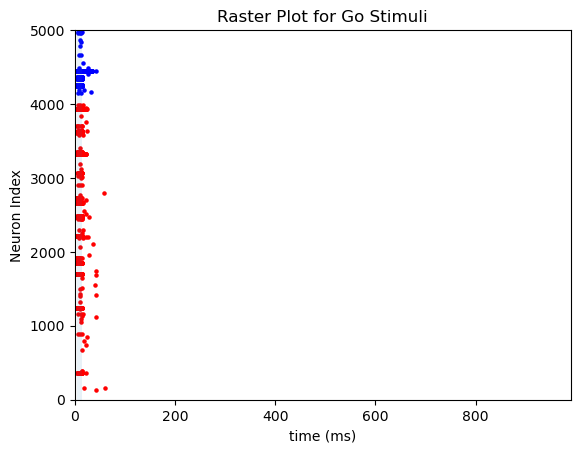

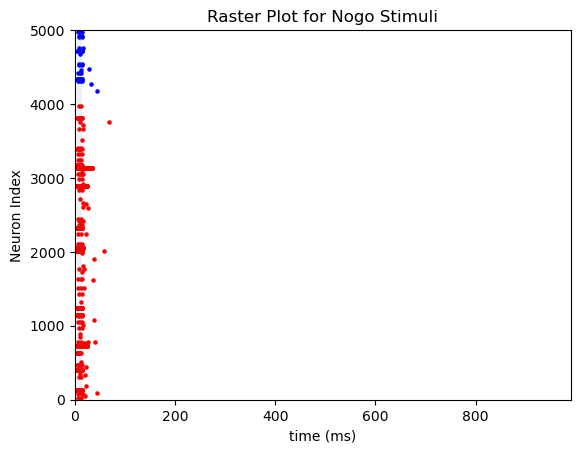

In [64]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

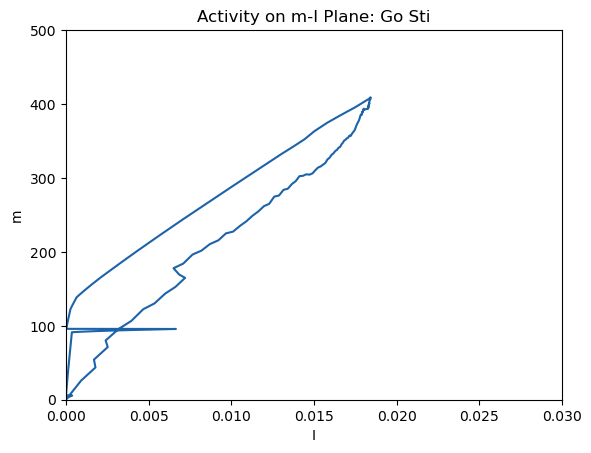

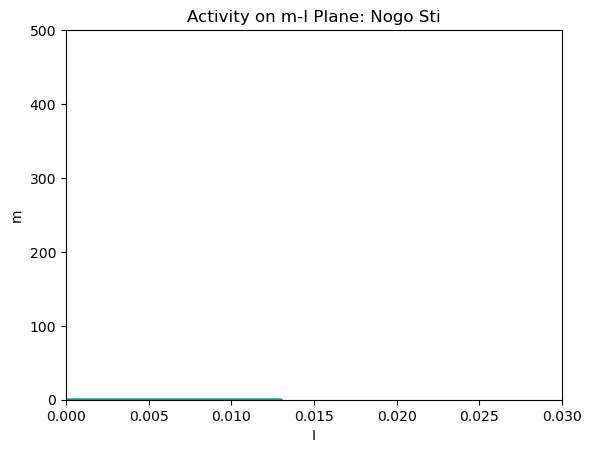

In [76]:
Sti_go = Input_go[:,int(6/dt)]
Sti_nogo = Input_nogo[:,int(6/dt)]
m = LRSNN.W_out.cpu().numpy()
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,500],xlim=[0,0.03])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,500],xlim=[0,0.03])

In [77]:
# 将synaptic decay time改为仅有slow
device = torch.device('cuda:0')
Input_go = torch.tensor(Input_go).to(device)
Input_nogo = torch.tensor(Input_nogo).to(device)
LRSNN_slow = LowRankSNN(N_E=4000,N_I=1000,RS= 1,taud_E=100,taud_I=100)
LRSNN_slow.conn = LRSNN.conn
LRSNN_slow.conn_lowrank = LRSNN.conn_lowrank
LRSNN_slow.conn_random = LRSNN.conn_random
LRSNN_slow.W_out = LRSNN.W_out
LRSNN = LRSNN.to(device)


In [78]:
# Start Simulation
Out_go, V_go, g_go, spk_go = LRSNN_slow(dt,Input_go)
Out_nogo, V_nogo, g_nogo, spk_nogo = LRSNN_slow(dt,Input_nogo)


Low-rank connectivity is added to all the connections
Low-rank connectivity is added to all the connections


In [79]:
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = g_go.cpu().numpy()
g_nogo = g_nogo.cpu().numpy()
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()

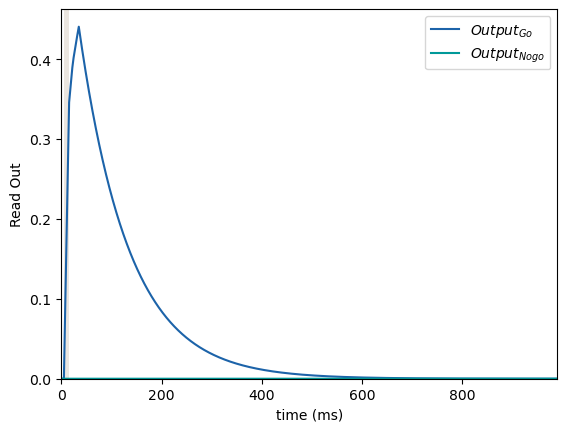

In [80]:

# Draw the results
color_Go = '#1C63A9'
color_Nogo = '#009999'
# Draw Output
fig, ax = plt.subplots()
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)

1.7599277 0.002
0.073124535 0.02


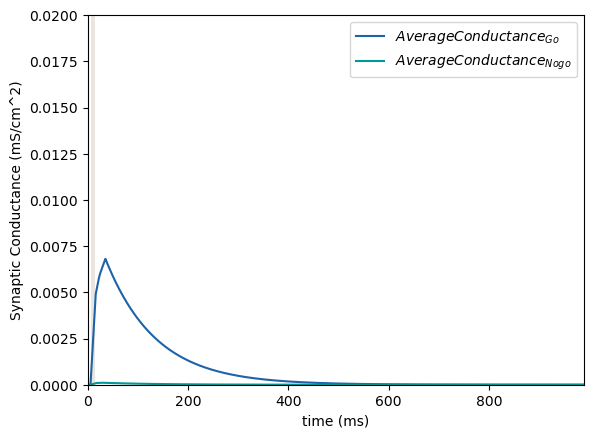

In [84]:
# Monitor the Average Conductance
fig, ax = plt.subplots()
Draw_Conductance(ax,g_go,color_Go,"Average Conductance_{Go}",dt,Input_go,ylim=[0,0.002])
Draw_Conductance(ax,g_nogo,color_Nogo,"Average Conductance_{Nogo}",dt,Input_nogo,ylim=[0,0.02])

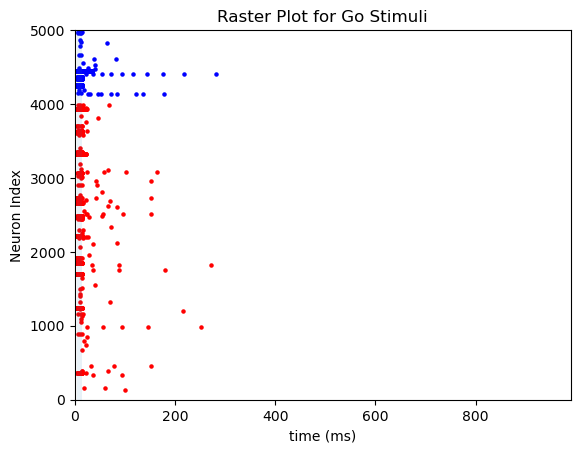

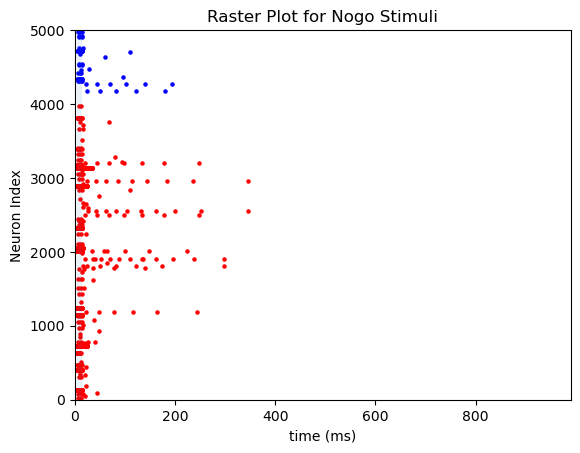

In [85]:
# Raster Plot
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots()
Draw_RasterPlot(ax,spk_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())

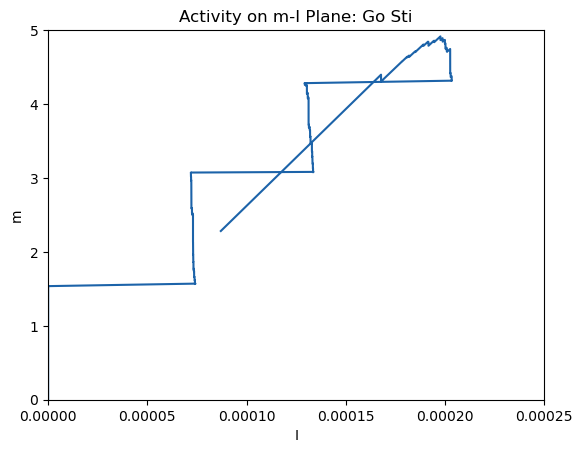

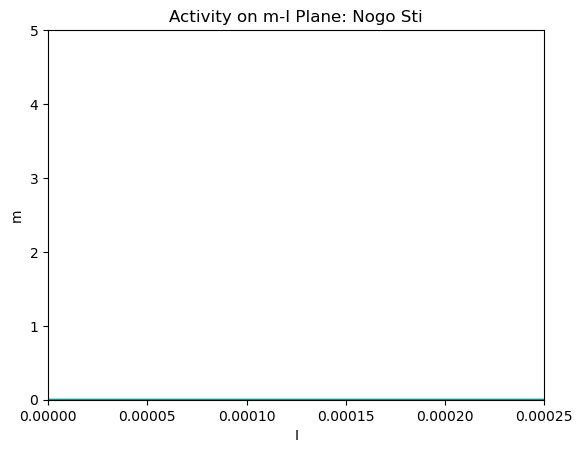

In [75]:
Sti_go = Input_go[:,int(6/dt)]
Sti_nogo = Input_nogo[:,int(6/dt)]
m = LRSNN.W_out.cpu().numpy()
# Monitor the Projection on m-I plane
fig, ax = plt.subplots()
Draw_Projection(ax,g_go,Sti_go.T,m,'Activity on m-I Plane: Go Sti',color_Go,xlabel='I',ylabel='m',ylim=[0,5],xlim=[0,0.00025])

fig, ax = plt.subplots()
Draw_Projection(ax,g_nogo,Sti_nogo.T,m,'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m',ylim=[0,5],xlim=[0,0.00025])